In [1]:
# https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# hyperparameters
num_epochs = 5
batch_size = 4
lr = 0.001

# dataset has PILImage images of range [0, 1]
# we transform them to tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root="./data",
                                             train=True,
                                             download=True,
                                             transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root="./data",
                                             train=False,
                                             download=True,
                                             transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


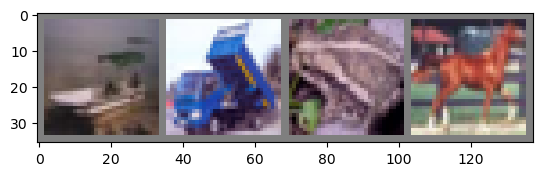

In [3]:
classes = ("plane", "car", "bird", "cat", "deer",
          "dog", "frog", "horse", "ship", "truck")

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 for the input size, because the images have 3 color channels
        # 6 output channels
        # 5 for the kernel size, presumably a 5x5 kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # pooling layer of size 2x2, with a stride of 2, meaning shift
        # 2 pixels to the right
        self.pool = nn.MaxPool2d(2, 2)
        # 6 is now the input size, because the output from the previous
        # layer is 6
        # 16 just because
        self.conv2 = nn.Conv2d(6, 16, 5)
        # fully connected layers, or dense, if you're coming from TensorFlow
        # you can swap the numbers 120 and 84 with whatever you want,
        # but 16 * 5 * 5 and 10 cannot be changed
        # it's 16 * 5 * 5 because that is the size returned when printing
        # the last layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # 10 because we have 10 different classes (see the dict above this cell)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x))) # -> n, 6, 14, 14 | conv, relu, then pool
        x = self.pool(F.relu(self.conv2(x))) # -> n, 6, 5, 5 | conv, relu, then pool
        x = x.view(-1, 16 * 5 * 5)           # -> n, 400 | flatten before going to a dense layer
        x = F.relu(self.fc1(x))              # -> n, 120 | relu, then dense
        x = F.relu(self.fc2(x))              # -> n, 84 | relu, then dense
        x = self.fc3(x)                      # -> n, 10 | dense
        return x
    
model = ConvNet().to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [6]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channls, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 2000 == 0:
            print(f"epoch [{epoch + 1}/{num_epochs}], step [{i + 1}/{n_total_steps}], loss: {loss.item():.4f}")
            
print("finished training")
PATH = "./cnn.pth"
torch.save(model.state_dict(), PATH)

epoch [1/5], step [2000/12500], loss: 2.2876
epoch [1/5], step [4000/12500], loss: 2.3043
epoch [1/5], step [6000/12500], loss: 2.2874
epoch [1/5], step [8000/12500], loss: 2.2942
epoch [1/5], step [10000/12500], loss: 2.1239
epoch [1/5], step [12000/12500], loss: 2.0120
epoch [2/5], step [2000/12500], loss: 1.6606
epoch [2/5], step [4000/12500], loss: 2.0438
epoch [2/5], step [6000/12500], loss: 1.4382
epoch [2/5], step [8000/12500], loss: 2.2515
epoch [2/5], step [10000/12500], loss: 2.0874
epoch [2/5], step [12000/12500], loss: 2.2474
epoch [3/5], step [2000/12500], loss: 1.3972
epoch [3/5], step [4000/12500], loss: 1.5176
epoch [3/5], step [6000/12500], loss: 1.9853
epoch [3/5], step [8000/12500], loss: 1.4324
epoch [3/5], step [10000/12500], loss: 1.4322
epoch [3/5], step [12000/12500], loss: 1.5962
epoch [4/5], step [2000/12500], loss: 2.0131
epoch [4/5], step [4000/12500], loss: 1.0651
epoch [4/5], step [6000/12500], loss: 1.7577
epoch [4/5], step [8000/12500], loss: 1.2692
epoc

In [8]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    acc = 100.0 * n_correct / n_samples
    print(f"accuracy of the network: {acc}%")
    
    for i in range(10):
        acc = 100.00 * n_class_correct[i] / n_class_samples[i]
        print(f"accuracy of {classes[i]}: {acc}%")

accuracy of the network: 49.184%
accuracy of plane: 50.96%
accuracy of car: 84.98%
accuracy of bird: 26.12%
accuracy of cat: 36.28%
accuracy of deer: 34.3%
accuracy of dog: 35.08%
accuracy of frog: 58.44%
accuracy of horse: 67.92%
accuracy of ship: 56.6%
accuracy of truck: 41.16%
